In [1]:
# imports
import csv
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
print('done!')

done!


In [2]:
# fix random seed so this can be reproduced
seed_val = 7
def reset_random_seeds():
    np.random.seed(seed_val)
    random.seed(seed_val)
    
reset_random_seeds()

In [3]:
# setting some specifications for model based on our data
time_steps = 10 # the size of each chunk of data being fed into the ml algorithm
shift_steps = 15 # the number of cells to shift the y values so the predictions line up with the current data
num_out = 16 # number of outputs to be predicted
test_files = 5 # the number of files to be set aside for testing

In [4]:
# put all the data into a dict for processing

# make list of file names
file_names = ['charlotte_sim_1_cooltoofast_sin_cos_time.csv', 'charlotte_sim_1_lowpeaktemp_sin_cos_time.csv',
              'charlotte_sim_1_lowtemps_sin_cos_time.csv','charlotte_sim_1_successful_sin_cos_time.csv', 
              'charlotte_sim_2_successful_sin_cos_time.csv',
              'charlotte_sim_2_v2_sin_cos_time.csv', 'charlotte_sim_3_sin_cos_time.csv',
              'denver_sim_1_sin_cos_time.csv', 'denver_sim_2_sin_cos_time.csv','denver_sim_3_sin_cos_time.csv',
              'detroit_sim_1_sin_cos_time.csv', 'detroit_sim_2_incomplete_sin_cos_time.csv', 
              'detroit_sim_2_successful_sin_cos_time.csv','detroit_sim_3_sin_cos_time.csv',
              'jacksonville_sim_1_sin_cos_time.csv', 'jacksonville_sim_2_sin_cos_time.csv',
              'jacksonville_sim_3_sin_cos_time.csv', 'lasvegas_sim_1_sin_cos_time.csv',
              'lasvegas_sim_2_sin_cos_time.csv', 'lasvegas_sim_3_sin_cos_time.csv']

# declare the dict 
file_dict = dict()
file_dict_len = len(file_names)

# loop through file names, open then, convert to list, and add to dict as a numpy array with i as the key
for i in range(file_dict_len):
    with open(file_names[i], "r") as f:
        reader = pd.read_csv(f)
        
        # always exclude heater due to errors in data collection 
        
        # with time
        # reader.drop(['heater'], inplace = True, axis = 1)
        
        # without time
        reader.drop(['heater','Sin', 'Cos'], inplace = True, axis = 1)
        
        file_data = [list(x) for x in reader.values]
        file_dict[i] = file_data
        
# check the conversion
# print(file_dict[0])

print("done!")

done!


In [5]:
# combine train files and test files into separate lists

full_train_x_set = [None] * 4500
full_train_y_set = [None] * 4500
full_test_x_set = [None] * 2000
full_test_y_set = [None] * 2000
trainInd = 0
testInd = 0

# separate training files
for i in range(0,file_dict_len - test_files):
    for j in range(0,len(file_dict[i])):
        #print(file_dict[i][j])
        full_train_x_set[trainInd] = file_dict[i][j]
        # with time
        # full_train_y_set[trainInd] = file_dict[i][j][2:num_out + 2]
        # without time
        full_train_y_set[trainInd] = file_dict[i][j][0:num_out]
        trainInd += 1

# separate testing files
for i in range(file_dict_len - test_files, file_dict_len):
    for j in range(0, len(file_dict[i])):
        full_test_x_set[testInd] = file_dict[i][j]
        # with time
        # full_train_y_set[trainInd] = file_dict[i][j][2:num_out + 2]
        # without time
        full_test_y_set[testInd] = file_dict[i][j][0:num_out]
        testInd += 1

# filter the Nones out of the lists
filtered_train_x_set = list(filter(None,full_train_x_set))
filtered_train_y_set = list(filter(None, full_train_y_set))
filtered_test_x_set = list(filter(None,full_test_x_set))
filtered_test_y_set = list(filter(None,full_test_y_set))
#print(filtered_train_set[len(filtered_train_set) - 5: len(filtered_train_set)])

# scale all the data 
x_scaler = MinMaxScaler()
scaled_train_x = x_scaler.fit_transform(filtered_train_x_set)
scaled_test_x = x_scaler.transform(filtered_test_x_set)

y_scaler = MinMaxScaler()
scaled_train_y = y_scaler.fit_transform(filtered_train_y_set)
scaled_test_y = y_scaler.transform(filtered_test_y_set)

# ** check everything **
# print(scaled_train[len(scaled_train) - 5: len(scaled_train)])
# print(scaled_test_y)
print("done!")

done!


In [6]:
# ** converting all training data into batches and putting it into a file **
print('start')

def train_batches(time_steps, shift_steps):
    # for each file
    train_set = [[None for x in range(2)] for i in range(4096)]
    file_sum = 0
    ind = 0
    for i in range(file_dict_len - test_files):
        # get num rows 
        current_len = len(file_dict[i])
        # start at i and i + shift_steps (j)
        for j in range(file_sum, file_sum + current_len - shift_steps + 1):
            # put input in col 0 and predictions in col 1
            train_set[ind][0] = scaled_train_x[j:j + time_steps]
            temp = scaled_train_x[j + shift_steps - 1: j + shift_steps]
            # with time
            # train_set[ind][1] = temp[0][2:num_out + 2]
            # without time
            train_set[ind][1] = temp[0][0:num_out]
            ind += 1
        file_sum += current_len        
    return train_set

train_set = train_batches(time_steps, shift_steps)
train_set = train_set[0:len(train_set) - 167][0:len(train_set) - 167]

# ** check everything **
#print(train_set[len(train_set) - 5: len(train_set)])

# with open('train_batches.csv', "w", newline = "") as x:
#     writeX = csv.writer(x)
#     writeX.writerows(train_set) 
    
print('done!')

start
done!


In [7]:
# ** converting all testing data into batches and putting it into a file **
print('start')

def test_batches(time_steps, shift_steps):
    # for each file
    test_set = [[None for x in range(2)] for i in range(2046)]
    file_sum = 0
    ind = 0
    for i in range(file_dict_len - 5, file_dict_len):
        # get num rows 
        current_len = len(file_dict[i])
        # start at i and i + 15 (j)
        for j in range(file_sum, file_sum + current_len - shift_steps + 1):
            #print(ind)
            test_set[ind][0] = scaled_test_x[j:j + time_steps]
            temp = scaled_test_x[j + shift_steps - 1: j + shift_steps]
            # with time
            # train_set[ind][1] = temp[0][2:num_out + 2]
            # without time
            test_set[ind][1] = temp[0][0:num_out]
            ind += 1
        file_sum += current_len        
    return test_set

test_set = test_batches(time_steps, shift_steps)
test_set = test_set[0:len(test_set) - 589][0:len(test_set) - 589]

# ** check everything **
#print(test_set[len(test_set) - 5:len(test_set)])
#test_set = np.array(test_set)

#with open('test_batches.csv', "w", newline = "") as x:
#    writeX = csv.writer(x)
#    writeX.writerows(test_set)
    
print('done!')

start
done!


In [8]:
# convert to numpy array and shuffle train/test set
train_set = np.array(train_set)
test_set = np.array(test_set)

np.random.shuffle(train_set)
np.random.shuffle(test_set)

# split into x and y
x_train = [train_set[i][0] for i in range(len(train_set))]
x_train = np.array(x_train)
y_train = [train_set[i][1] for i in range(len(train_set))]
y_train = np.array(y_train)

x_test = [test_set[i][0] for i in range(len(test_set))]
x_test = np.array(x_test)
y_test = [test_set[i][1] for i in range(len(test_set))]
y_test = np.array(y_test)

# check the shapes
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print('done!')

(3929, 10, 34)
(3929, 16)
(1457, 10, 34)
(1457, 16)
done!


<ipython-input-8-b147467bc2fb>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  train_set = np.array(train_set)
<ipython-input-8-b147467bc2fb>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  test_set = np.array(test_set)


In [9]:
# ** random forest regressor **

#flatten our training and testing data 
train_flatten = np.reshape(x_train, [x_train.shape[0],x_train.shape[1]*x_train.shape[2]])
test_flatten = np.reshape(x_test, [x_test.shape[0],x_test.shape[1]*x_test.shape[2]])

# make the regressor using the params found in gridsearch
model = RandomForestRegressor(n_estimators = 150, max_depth = 5, criterion = 'mse')

#fit the model
#model.fit(train_flatten, y_train, epochs=50, batch_size=batch_size, validation_data=(test_flatten, y_test), verbose = 1, shuffle=False)
model.fit(train_flatten, y_train)

# predict train and test
rfr_train_pred = model.predict(train_flatten)
rfr_test_pred = model.predict(test_flatten)

print('done!')

done!


In [10]:
# scale the predictions back
train_pred = y_scaler.inverse_transform(rfr_train_pred)
y_train = y_scaler.inverse_transform(y_train)

test_pred = y_scaler.inverse_transform(rfr_test_pred)
y_test = y_scaler.inverse_transform(y_test)

# get RMSE
trainScore = math.sqrt(mean_squared_error(y_train, train_pred)) 
testScore = math.sqrt(mean_squared_error(y_test, test_pred))
print('Train RMSE Score: %.2f' % (trainScore))
print('Test RMSE Score: %.2f' % (testScore))
print()

# get mean absolute error
print("Train Mean Absolute Error: %.2f" % (mean_absolute_error(y_train, train_pred)))
print("Test Mean Absolute Error: %.2f" % (mean_absolute_error(y_test, test_pred)))
print()

#get r2 score
print("Train R2 Score: %.2f" % r2_score(y_train,train_pred))
print("Test R2 Score: %.2f" % r2_score(y_test, test_pred))

Train RMSE Score: 0.49
Test RMSE Score: 0.75

Train Mean Absolute Error: 0.34
Test Mean Absolute Error: 0.54

Train R2 Score: 0.94
Test R2 Score: 0.84


start


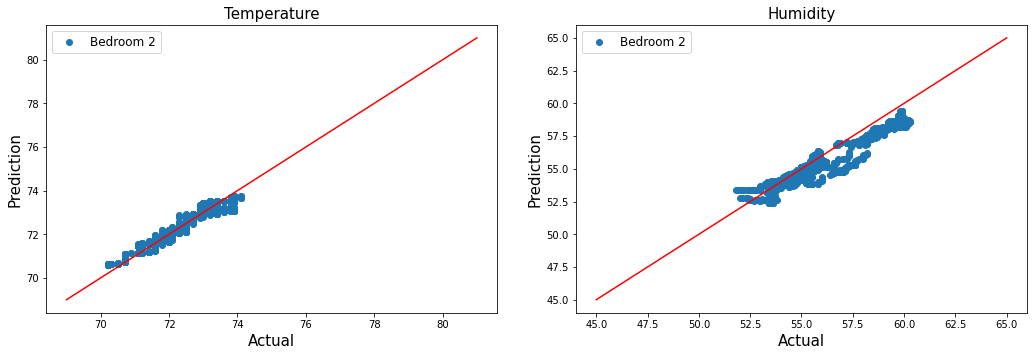

done


In [18]:
print('start')
labels = ["Outside","Outside","Bedroom 1","Bedroom 1","Kitchen","Kitchen","Dining Room",
          "Dining Room","Bathroom","Bathroom","Living Room 1","Living Room 1","Living Room 2","Living Room 2",
          "Bedroom 2","Bedroom 2"]

def plot_room(room_num, filename):
    
    # set figure size and make two charts
    fig = plt.figure(figsize = (15,10))
    ax1 = fig.add_subplot(222, label = '1')
    ax2 = fig.add_subplot(221, label = '2')
    
    # for graphing all rooms
    if room_num == -1:
        ind = 0
        for i in range(0,y_test.shape[1],2):
            ax1.scatter(y_test[:,i], test_pred[:,i], label = labels[ind])
            ax2.scatter(y_test[:,i + 1], test_pred[:, i + 1], label = labels[ind + 1])
            ind += 2
    # for graphing individual rooms
    else:
        if room_num == 6:
            room_num += 1
            
        ax1.scatter(y_test[:,room_num * 2], test_pred[:,room_num * 2], label = labels[room_num * 2])
        ax2.scatter(y_test[:,room_num * 2 + 1], test_pred[:,room_num * 2 + 1], label = labels[room_num * 2 + 1])
        
        # the living room has two sensors
        if room_num == 5:
            ax1.scatter(y_test[:,room_num * 2 + 2], test_pred[:, room_num * 2 + 2], label = labels[room_num * 2 + 2], color = 'plum')
            ax2.scatter(y_test[:,room_num * 2 + 3], test_pred[:, room_num * 2 + 3], label = labels[room_num * 2 + 3], color = 'plum')

    # plot accuracy line
    ax1.plot([45, 65], [45, 65], color = 'red')
    ax2.plot([69, 81], [69, 81], color = 'red')
    
    ax1.set_title('Humidity', fontsize = 15)
    ax2.set_title('Temperature', fontsize = 15)
    ax1.set_xlabel('Actual', fontsize = 15)
    ax1.set_ylabel('Prediction', fontsize = 15)
    ax2.set_xlabel('Actual', fontsize = 15)
    ax2.set_ylabel('Prediction', fontsize = 15)
    fig.tight_layout(pad = 3.0)
    plt.legend(prop = {'size':12})
    ax1.legend(prop = {'size':12})
    ax2.legend(prop = {'size':12})
    plt.show()
    fig.savefig(filename, dpi = 1200)

# with time
# plot_room(6, filename = 'Random_Forest_time_temp_hum_graphs_bedroom_2')

# without time
plot_room(6, filename = 'Random_Forest_no_time_temp_hum_graphs_bedroom_2')

# ** room numbers **
#-1: All Rooms
# 0: Outside
# 1: Bedroom 1 
# 2: Kitchen 
# 3: Dining Room
# 4: Bathroom  
# 5: Living Rm 1 
# 5: Living Rm 2 
# 7: Bedroom 2 

print('done')